In [2]:
import shutil

source_dir = "/kaggle/input/plantvillage-dataset/color/Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot"
destination_dir = "/kaggle/working/Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot"
shutil.copytree(source_dir, destination_dir)

source_dir = "/kaggle/input/plantvillage-dataset/color/Corn_(maize)___Common_rust_"
destination_dir = "/kaggle/working/Corn_(maize)___Common_rust_"
shutil.copytree(source_dir, destination_dir)

source_dir = "/kaggle/input/plantvillage-dataset/color/Corn_(maize)___Northern_Leaf_Blight"
destination_dir = "/kaggle/working/Corn_(maize)___Northern_Leaf_Blight"
shutil.copytree(source_dir, destination_dir)

source_dir = "/kaggle/input/plantvillage-dataset/color/Corn_(maize)___healthy"
destination_dir = "/kaggle/working/Corn_(maize)___healthy"
shutil.copytree(source_dir, destination_dir)

'/kaggle/working/Corn_(maize)___healthy'

In [3]:
import os

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras import models, layers
import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.utils import to_categorical, plot_model


2024-06-01 01:28:59.116915: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-01 01:28:59.117063: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-01 01:28:59.245074: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
data_path='/kaggle/working/'

In [5]:
def create_dataframe(data_path):
    filepaths = []
    labels = []

    for fold in os.listdir(data_path):
        f_path = os.path.join(data_path, fold)
        if os.path.isdir(f_path):
            imgs = os.listdir(f_path)
            for img in imgs:
                img_path = os.path.join(f_path, img)
                filepaths.append(img_path)
                labels.append(fold)

    fseries = pd.Series(filepaths, name='Filepaths')
    lseries = pd.Series(labels, name='Labels')
    return pd.concat([fseries, lseries], axis=1)

# Create DataFrame for the dataset
df = create_dataframe(data_path)

In [6]:
df

,Filepaths,Labels
0,/kaggle/working/Corn_(maize)___Northern_Leaf_B...,Corn_(maize)___Northern_Leaf_Blight
1,/kaggle/working/Corn_(maize)___Northern_Leaf_B...,Corn_(maize)___Northern_Leaf_Blight
2,/kaggle/working/Corn_(maize)___Northern_Leaf_B...,Corn_(maize)___Northern_Leaf_Blight
3,/kaggle/working/Corn_(maize)___Northern_Leaf_B...,Corn_(maize)___Northern_Leaf_Blight
4,/kaggle/working/Corn_(maize)___Northern_Leaf_B...,Corn_(maize)___Northern_Leaf_Blight
...,...,...
3847,/kaggle/working/Corn_(maize)___Cercospora_leaf...,Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...
3848,/kaggle/working/Corn_(maize)___Cercospora_leaf...,Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...
3849,/kaggle/working/Corn_(maize)___Cercospora_leaf...,Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...
3850,/kaggle/working/Corn_(maize)___Cercospora_leaf...,Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...


In [7]:
# Step 1: Split into 70% training and 30% dummy
train_df, dummy_df = train_test_split(df, train_size=0.7, shuffle=True, random_state=42)

# Step 2: Split dummy_df into 20% testing and 10% validation
test_df, valid_df = train_test_split(dummy_df, train_size=2/3, shuffle=True, random_state=42)

In [8]:
print(train_df.shape)
print(dummy_df.shape)
print(valid_df.shape)
print(test_df.shape)

(2696, 2)
(1156, 2)
(386, 2)
(770, 2)


In [9]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 2696 validated image filenames belonging to 4 classes.
Found 386 validated image filenames belonging to 4 classes.
Found 770 validated image filenames belonging to 4 classes.


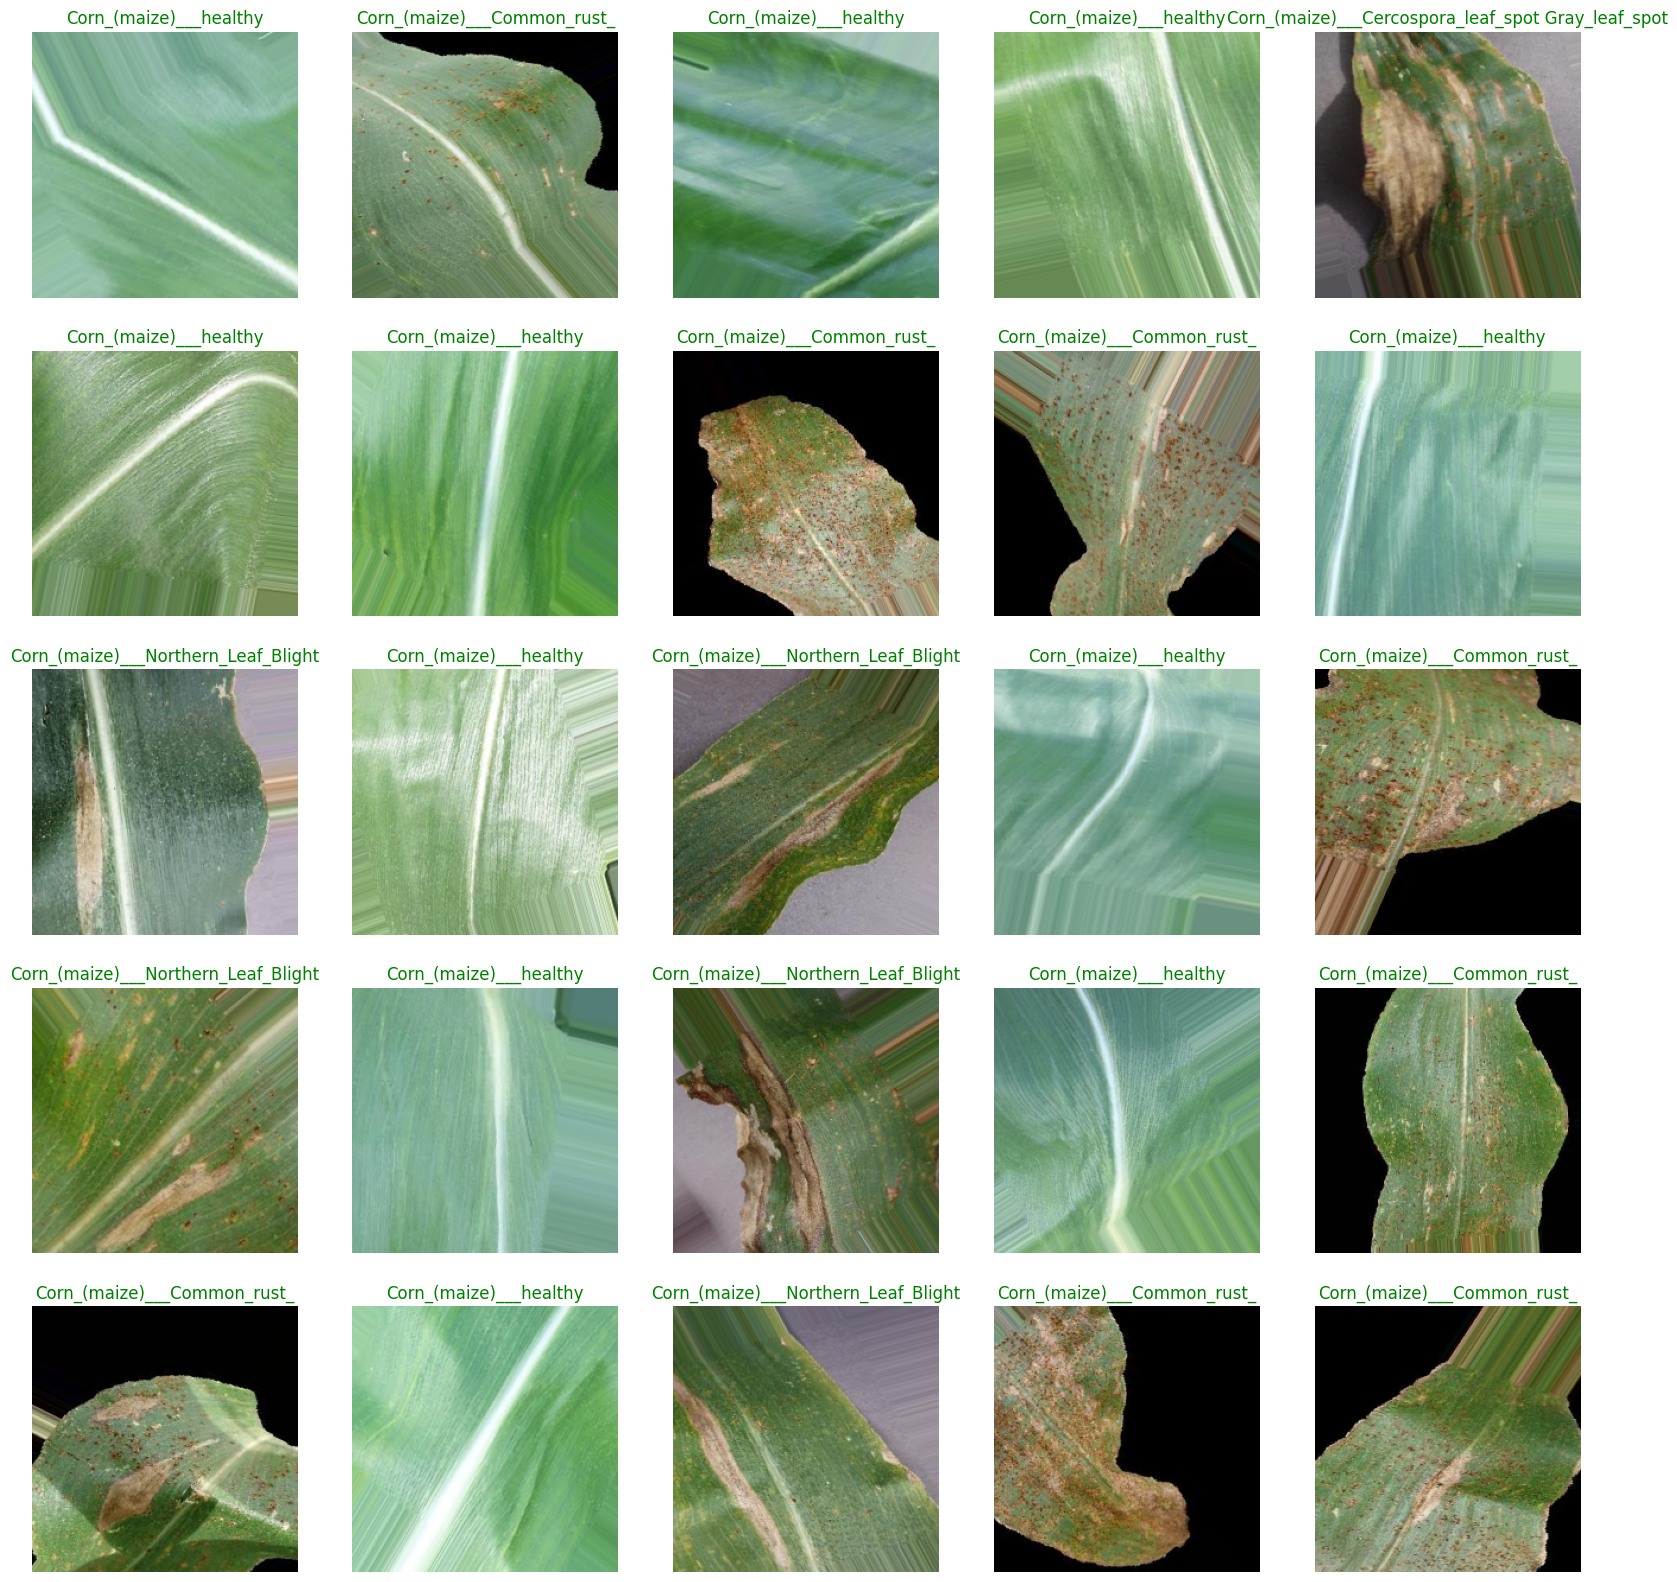

In [11]:

def show_images(image_gen):
    class_dict = image_gen.class_indices
    classes = list(class_dict.keys())
    
    images, labels = next(image_gen)
    
    plt.figure(figsize=(20, 20))
    
    num_images = min(len(labels), 25)
    
    for i in range(num_images):
        plt.subplot(5, 5, i + 1)
        
        image = images[i]
        
        plt.imshow(image)
        
        index = np.argmax(labels[i])
        class_name = classes[index]
        
        plt.title(class_name, color="green", fontsize=12)
        plt.axis('off')
    
    plt.show()

show_images(train_generator)

In [31]:

input_shape = (224, 224, 3) 
n_classes = len(train_generator.class_indices)

model = keras.Sequential([
    keras.layers.Conv2D(filters=64, kernel_size=(7, 7), strides=(3, 3), activation='relu', input_shape=input_shape),
    keras.layers.MaxPool2D(pool_size=(3, 3)),

    keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),

    keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),

    keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),

    keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),

    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(512, activation='relu'),

    keras.layers.Dense(n_classes, activation='softmax')
])


model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.Adam(),
    metrics=['accuracy']
)

model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 73, 73, 64)     │         9,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 6, 6, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 3, 3, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,512,452 (5.77 MB)

 Trainable params: 1,512,452 (5.77 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
history = model.fit(
    train_generator,
    batch_size=32,
    validation_data=valid_generator,
    epochs=100
)

Epoch 1/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 35s 339ms/step - accuracy: 0.4442 - loss: 1.1344 - val_accuracy: 0.5881 - val_loss: 0.7368
Epoch 2/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 30s 320ms/step - accuracy: 0.6082 - loss: 0.7590 - val_accuracy: 0.7824 - val_loss: 0.5161
Epoch 3/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 30s 325ms/step - accuracy: 0.7782 - loss: 0.5160 - val_accuracy: 0.8627 - val_loss: 0.3203
Epoch 4/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 31s 330ms/step - accuracy: 0.8337 - loss: 0.3742 - val_accuracy: 0.8705 - val_loss: 0.2522
Epoch 5/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 30s 332ms/step - accuracy: 0.8250 - loss: 0.3658 - val_accuracy: 0.8575 - val_loss: 0.2600
Epoch 6/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 31s 332ms/step - accuracy: 0.8584 - loss: 0.2699 - val_accuracy: 0.9378 - val_loss: 0.2019
Epoch 7/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 31s 333ms/step - accuracy: 0.8764 - loss: 0.2740 - val_accuracy: 0.8912 - val_loss: 0.1985
Epoch 8/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 31s 331ms/step - accuracy: 0.8859 - loss: 0.2520 - 

In [33]:
scores = model.evaluate(test_generator)
scores

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9722 - loss: 0.0791


[0.08285832405090332, 0.9688311815261841]

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step


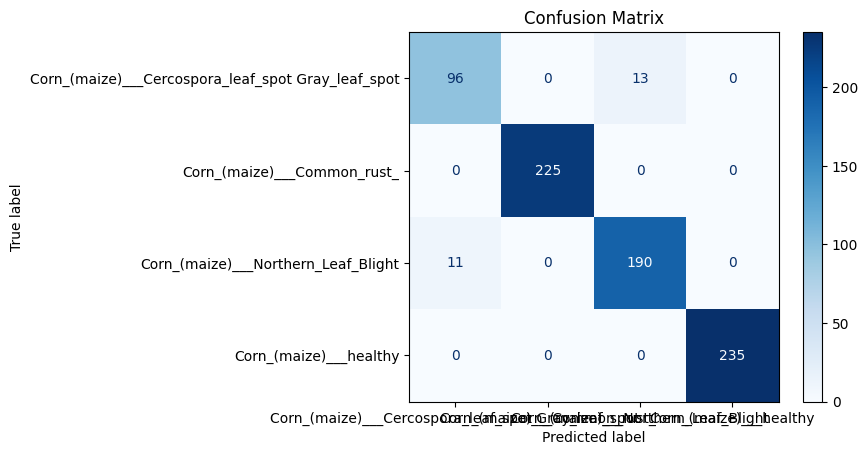

In [34]:
predictions = model.predict(test_generator)

predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_generator.classes

cm = confusion_matrix(true_classes, predicted_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [35]:
test_generator.reset()
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_generator.classes

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


In [36]:
from sklearn.metrics import classification_report 

class_labels = list(test_generator.class_indices.keys())
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

                                                    precision    recall  f1-score   support

Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.90      0.88      0.89       109
                       Corn_(maize)___Common_rust_       1.00      1.00      1.00       225
               Corn_(maize)___Northern_Leaf_Blight       0.94      0.95      0.94       201
                            Corn_(maize)___healthy       1.00      1.00      1.00       235

                                          accuracy                           0.97       770
                                         macro avg       0.96      0.96      0.96       770
                                      weighted avg       0.97      0.97      0.97       770



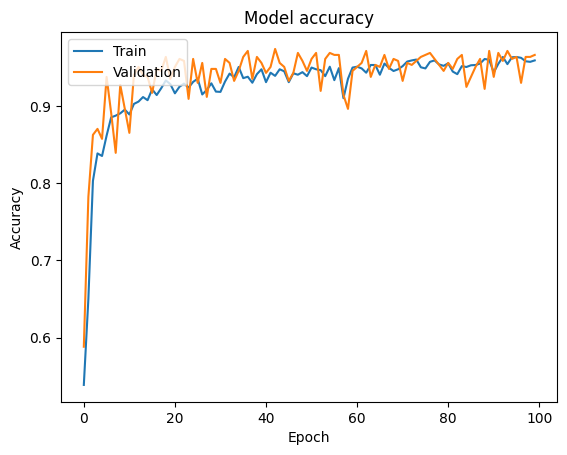

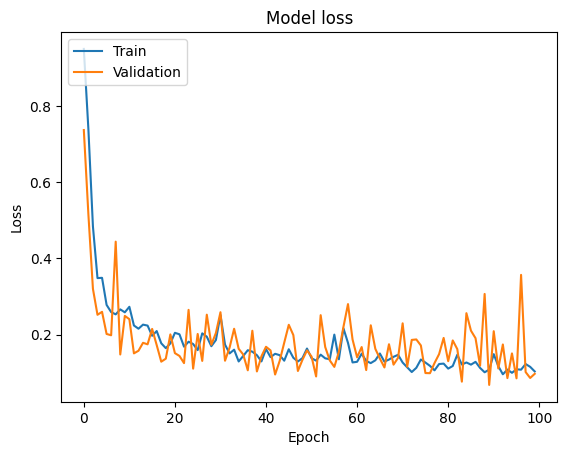

In [37]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [38]:

class_names = list(test_generator.class_indices.keys())

images_batch, labels_batch = next(test_generator)

first_image = images_batch[0]
first_label = np.argmax(labels_batch[0])  

batch_prediction = model.predict(images_batch)
predicted_label_index = np.argmax(batch_prediction[0])

print("Actual label:", class_names[first_label])
print("Predicted label:", class_names[predicted_label_index])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step
Actual label: Corn_(maize)___Common_rust_
Predicted label: Corn_(maize)___Common_rust_


In [39]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

for images_batch, labels_batch in test_generator:
    for i in range(min(len(images_batch), 9)):
        predicted_class, confidence = predict(model, images_batch[i])
        actual_class = class_names[np.argmax(labels_batch[i])] 
        
        print(f"Actual: {actual_class}, Predicted: {predicted_class}, Confidence: {confidence}%")
        
    break  


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step
Actual: Corn_(maize)___healthy, Predicted: Corn_(maize)___healthy, Confidence: 100.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Actual: Corn_(maize)___healthy, Predicted: Corn_(maize)___healthy, Confidence: 100.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Actual: Corn_(maize)___Common_rust_, Predicted: Corn_(maize)___Common_rust_, Confidence: 100.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Actual: Corn_(maize)___Common_rust_, Predicted: Corn_(maize)___Common_rust_, Confidence: 100.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Actual: Corn_(maize)___Common_rust_, Predicted: Corn_(maize)___Common_rust_, Confidence: 100.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Actual: Corn_(maize)___Northern_Leaf_Blight, Predicted: Corn_(maize)___Northern_Leaf_Blight, Confidence: 100.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Actual: Corn_(maize)___healthy, Predicted: Corn_(maize)___healthy, Confidence: 100.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Actual: Corn_(maize)___Common_rust_, 

In [40]:
model.save("Model_C_v4.h5")